In [3]:
import xml.etree.ElementTree as ET
import csv

def xml_to_csv(xml_file, csv_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Open the CSV file for writing
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['image_id', 'label', 'x', 'y', 'presumed_location'])

        # Iterate through each image in the XML
        for image in root.findall('image'):
            image_id = image.get('id')
            for points in image.findall('points'):
                label = points.get('label')
                coords = points.get('points').split(',')
                presumed_location = points.find('attribute[@name="Presumed_Location"]').text
                
                # Write the row for each keypoint
                writer.writerow([image_id, label, coords[0], coords[1], presumed_location])


# Usage
xml_file = r'C:\Users\sshak\Downloads\archive (2)\annotations.xml'
csv_file = 'output1.csv'
xml_to_csv(xml_file, csv_file)


PermissionError: [Errno 13] Permission denied: 'output1.csv'

In [2]:
import pandas as pd

# Read the CSV file
csv_file = 'output1.csv'
data = pd.read_csv(csv_file)

# Drop the 'presumed_location' column

# Sort the DataFrame by 'label' and 'image_id'
data_sorted = data.sort_values(by=['image_id', 'label'])

# Reset index if needed
data_sorted.reset_index(drop=True, inplace=True)


data_sorted = data_sorted.groupby('image_id').agg(lambda x: list(x)).reset_index()
data_sorted = data_sorted.drop(columns=['label'])
# data_sorted.set_index('image_id', inplace=True)

# Write the sorted DataFrame to a new CSV file
output_file = 'sorted_output.csv'
data_sorted.to_csv(output_file, index=False)

# Confirm the output
print(data_sorted.head())




   image_id                                                  x  \
0         0  [1455.34, 1371.13, 1152.69, 974.97, 810.17, 16...   
1         1  [1469.62, 1379.63, 978.18, 555.62, 554.75, 167...   
2         2  [1849.69, 1976.06, 1593.61, 1171.18, 640.9, 21...   
3         3  [1599.71, 1675.28, 1459.29, 1075.28, 831.86, 1...   
4         4  [2310.54, 2740.42, 2610.95, 2781.65, 2222.4, 2...   

                                                   y  
0  [1206.07, 1385.42, 1381.02, 993.31, 465.79, 14...  
1  [1517.95, 1812.04, 1906.83, 2072.72, 1571.32, ...  
2  [1834.31, 2068.8, 2087.05, 2305.87, 2386.54, 1...  
3  [1363.03, 1622.92, 1711.1, 1581.41, 1173.66, 1...  
4  [2879.0, 2606.14, 2259.51, 2975.49, 3141.39, 2...  


In [10]:
import ast
df=data_sorted

# Assuming df is your DataFrame
# Expand the lists in 'x' and 'y' columns into separate columns
x_cols = pd.DataFrame(df['x'].tolist(), columns=[f'x_{i}' for i in range(len(df['x'][0]))])
y_cols = pd.DataFrame(df['y'].tolist(), columns=[f'y_{i}' for i in range(len(df['y'][0]))])

# Concatenate the new columns with the original DataFrame
result_df = pd.concat([df[['image_id']], x_cols, y_cols], axis=1)
result_df.to_csv(output_file, index=False)
# Display the resulting DataFrame
print(result_df)



    image_id      x_0      x_1      x_2      x_3      x_4      x_5      x_6  \
0          0  1455.34  1371.13  1152.69   974.97   810.17  1627.15  1914.41   
1          1  1469.62  1379.63   978.18   555.62   554.75  1674.58  2112.12   
2          2  1849.69  1976.06  1593.61  1171.18   640.90  2109.22  2415.28   
3          3  1599.71  1675.28  1459.29  1075.28   831.86  1962.95  2322.63   
4          4  2310.54  2740.42  2610.95  2781.65  2222.40  2964.57  3067.17   
5          5  1821.44  1788.97  2008.95  2390.83  2694.78  1469.84  1025.61   
6          6  3906.64  4048.92  3938.26  3166.79  4128.50  4165.49  4963.17   
7          7  1156.35  1286.12  1102.76   721.95   760.81  1459.00  1416.07   
8          8  2207.40  1938.76  1900.16  1753.07  1794.84  1553.65  1180.49   
9          9  1690.09  1690.09  1182.42  1051.91  1021.34  2245.78  2507.42   
10        10  1923.62  1892.50  1754.40  1582.36  1532.42  2175.22  2648.33   
11        11  2782.80  2620.48  2176.99  1562.12   9

## Import Packages

In [2]:
# inbuilt packages 

import os 
from PIL import Image
from tqdm import tqdm 

# Datascience Packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

# PyTorch Related Packages 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import models

## Hyper Parameters

In [3]:
batch_size = 16

model_input_size = 224
n_epoch = 10
learning_rate = 0.0001

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## DataLoader

In [5]:
class FaceKeyPointData(Dataset):
    def __init__(self, csv_path='sorted_output.csv',img=r"C:\Users\sshak\Downloads\archive (2)\PoseEstimation\fiile_info.csv",device=torch.device('cpu')):
        super(FaceKeyPointData).__init__()
        self.csv_path = csv_path
        self.img=img
        self.df = pd.read_csv(self.csv_path)
        self.imgdf=pd.read_csv(self.img)
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.device = device

    def __len__(self):
        return len(self.df) 

    def __getitem__(self, index):
        img, original_size = self.get_img(index) 
        key_points = self.get_keypoints(index=index, original_size= original_size)
        return img, key_points
    
    def get_img(self, index):
        collage_name_series = self.imgdf.loc[self.imgdf['image_id'] == index, 'collage_name']
        img_path = os.path.join(r"C:\Users\sshak\Downloads\archive (2)\PoseEstimation",collage_name_series.iloc[0])
        img = Image.open(img_path).convert('RGB')
        original_size = img.size 

        # preprocess Image
        img = img.resize((model_input_size, model_input_size))
        img = np.asarray(img) / 255.0
        img = torch.tensor(img).permute(2, 0 , 1)
        img = self.normalize(img).float()
        return img.to(self.device), original_size
    
    def get_keypoints(self, index, original_size):
        kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32)
        kp_x = kp[:18] / original_size[0]
        kp_y = kp[18:] / original_size[1]
        kp = np.concatenate([kp_x, kp_y])
        return torch.tensor(kp).to(self.device)

    def load_img(self, index):
        collage_name_series = self.imgdf.loc[self.imgdf['image_id'] == index, 'collage_name']
        if not collage_name_series.empty:

            img_path = os.path.join(r"C:\Users\sshak\Downloads\archive (2)\PoseEstimation",collage_name_series.iloc[0])
            img = Image.open(img_path).convert('RGB')
            img = img.resize((model_input_size, model_input_size))
            return np.asarray(img) / 255.0


training_data = FaceKeyPointData(device=device)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
def get_resnet18_model(device):
    # Load pretrained ResNet18 model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Freeze layers (optional, if you want to fine-tune only the classifier)
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify the ResNet model's fully connected layer to predict 36 outputs (18 keypoints with x, y coordinates)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),  # First layer: Reduce dimensionality
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 36),                    # Output layer: 36 coordinates
        nn.Sigmoid()                           # Sigmoid for normalized output (0-1 range)
    )
    
    return model.to(device=device)

# Instantiate and move the model to the device
model = get_resnet18_model(device=device)
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
def train_batch(imgs, kps, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    # forward Pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)

    # backward Pass
    loss.backward()
    optimizer.step()

    return loss 
train_loss = []
test_loss = []

for epoch in range(1, n_epoch+1):
    epoch_train_loss, epoch_test_loss = 0, 0 

    # train 
    for images, kps in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        # images, kps = 
        loss = train_batch(images, kps, model, criterion, optimizer)
        epoch_train_loss+= loss.item()
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)
    

    print(f"Epoch {epoch} of {n_epoch}: Training Loss: {epoch_train_loss}")

Training 1 of 10: 100%|██████████| 2/2 [00:11<00:00,  5.95s/it]


Epoch 1 of 10: Training Loss: 0.16962354630231857


Training 2 of 10: 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


Epoch 2 of 10: Training Loss: 0.15853232890367508


Training 3 of 10: 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


Epoch 3 of 10: Training Loss: 0.15019631385803223


Training 4 of 10: 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch 4 of 10: Training Loss: 0.1436651647090912


Training 5 of 10: 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch 5 of 10: Training Loss: 0.1377011090517044


Training 6 of 10: 100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


Epoch 6 of 10: Training Loss: 0.13403163105249405


Training 7 of 10: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


Epoch 7 of 10: Training Loss: 0.1307143047451973


Training 8 of 10: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Epoch 8 of 10: Training Loss: 0.12489102780818939


Training 9 of 10: 100%|██████████| 2/2 [00:09<00:00,  4.58s/it]


Epoch 9 of 10: Training Loss: 0.12316957861185074


Training 10 of 10: 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]

Epoch 10 of 10: Training Loss: 0.12726643681526184


In [26]:
batch_img, batch_key_points = next(iter(train_dataloader))
batch_key_points.shape

torch.Size([16, 36])

In [17]:

img_tensor, batch_key_points = training_data.get_img(10)

In [20]:
img_tensor.shape

torch.Size([3, 224, 224])

## Data Visualization

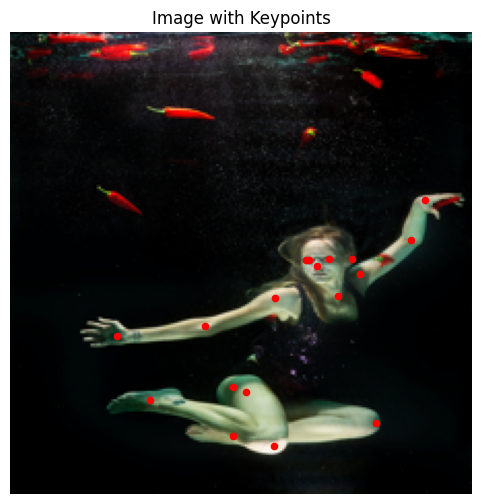

In [6]:
import matplotlib.pyplot as plt

img_index =  2# Example index for the imag
img = training_data.load_img(img_index)  # Load the image

# Plot the image
plt.figure(figsize=(8, 6))
plt.title("Image with Keypoints")
plt.imshow(img)

# Load the keypoints
img_tensor, kp_s = training_data[img_index]
kp_s = kp_s.to('cpu').squeeze()  # Remove the extra dimension

# Rescale the keypoints back to the original image size
original_size = img.shape[0:2]  # Get original size (height, width)
kp_x = kp_s[:18] * original_size[1]  # X coordinates
kp_y = kp_s[18:] * original_size[0]  # Y coordinates

# Scatter the key points
plt.scatter(kp_x, kp_y, c='r', s=20)  # Larger dots for better visibility


# Show the plot
plt.axis('off')  # Turn off axis
plt.show()


## Model Building 

In [7]:
def get_model(device):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for layers in model.parameters():
        layers.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 36),
        nn.Sigmoid()
    )
    return model.to(device=device)
model = get_model(device=device)

In [23]:
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

torch.Size([36])

In [9]:
def train_batch(imgs, kps, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    # forward Pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)

    # backward Pass
    loss.backward()
    optimizer.step()

    return loss 

In [14]:
train_loss = []
test_loss = []

for epoch in range(1, n_epoch+1):
    epoch_train_loss, epoch_test_loss = 0, 0 

    # train 
    for images, kps in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        # images, kps = 
        loss = train_batch(images, kps, model, criterion, optimizer)
        epoch_train_loss+= loss.item()
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)
    

    print(f"Epoch {epoch} of {n_epoch}: Training Loss: {epoch_train_loss}")

Training 1 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 1 of 10: Training Loss: 0.06216670759022236


Training 2 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


Epoch 2 of 10: Training Loss: 0.06736628152430058


Training 3 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch 3 of 10: Training Loss: 0.06970839202404022


Training 4 of 10: 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch 4 of 10: Training Loss: 0.06810560822486877


Training 5 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


Epoch 5 of 10: Training Loss: 0.06702843122184277


Training 6 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


Epoch 6 of 10: Training Loss: 0.06437830440700054


Training 7 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


Epoch 7 of 10: Training Loss: 0.05777610279619694


Training 8 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


Epoch 8 of 10: Training Loss: 0.06852036342024803


Training 9 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 9 of 10: Training Loss: 0.06536616571247578


Training 10 of 10: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]

Epoch 10 of 10: Training Loss: 0.06873491406440735


## Training Pipeline

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(device)



Epoch [1/10], Loss: 0.0473
Epoch [2/10], Loss: 0.0369
Epoch [3/10], Loss: 0.0268
Epoch [4/10], Loss: 0.0225
Epoch [5/10], Loss: 0.0220
Epoch [6/10], Loss: 0.0197
Epoch [7/10], Loss: 0.0199
Epoch [8/10], Loss: 0.0192
Epoch [9/10], Loss: 0.0191
Epoch [10/10], Loss: 0.0161
Training complete!


## Train and Test Loss Curve

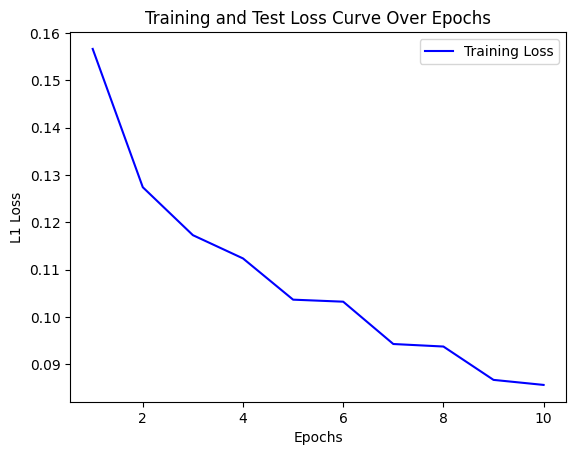

In [7]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
# plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title("Training and Test Loss Curve Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.show()

## Result visualization

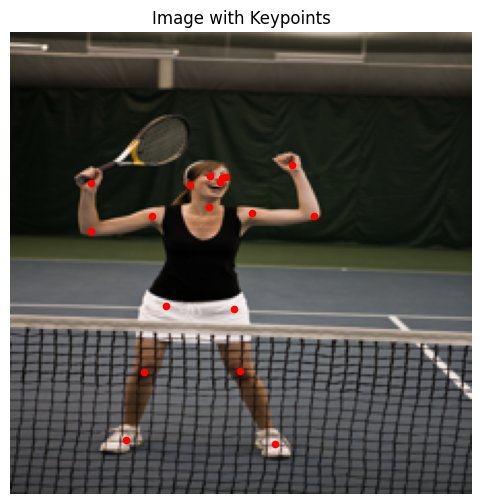

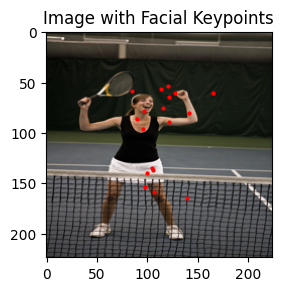

In [8]:

img_index =  1# Example index for the imag
img = training_data.load_img(img_index)  # Load the image

# Plot the image
plt.figure(figsize=(8, 6))
plt.title("Image with Keypoints")
plt.imshow(img)

# Load the keypoints
img_tensor, kp_s = training_data[img_index]
kp_s = kp_s.to('cpu').squeeze()  # Remove the extra dimension

# Rescale the keypoints back to the original image size
original_size = img.shape[0:2]  # Get original size (height, width)
kp_x = kp_s[:18] * original_size[1]  # X coordinates
kp_y = kp_s[18:] * original_size[0]  # Y coordinates

# Scatter the key points
plt.scatter(kp_x, kp_y, c='r', s=20)  # Larger dots for better visibility


# Show the plot
plt.axis('off')  # Turn off axis
plt.show()


plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img, kp_s_ = training_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()
kp_s = kp_s.to('cpu')

# Scatter the key points
plt.scatter(kp_s[:18] * model_input_size, kp_s[18:] * model_input_size, c='r', s=4)

# Plot lines connecting the key points
# plt.plot(kp_s[:18] * model_input_size, kp_s[18:] * model_input_size, c='y')

# Show the plot
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import os

# Dataset class
class FaceKeyPointData(Dataset):
    def __init__(self, csv_path='sorted_output.csv', img=r"C:\Users\sshak\Downloads\archive (2)\PoseEstimation\fiile_info.csv", device=torch.device('cpu')):
        super(FaceKeyPointData).__init__()
        self.csv_path = csv_path
        self.img = img
        self.df = pd.read_csv(self.csv_path)
        self.imgdf = pd.read_csv(self.img)
        self.device = device
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        # Data Augmentation for training
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.Resize((model_input_size, model_input_size)),
            transforms.ToTensor(),
            self.normalize
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img, original_size = self.get_img(index)
        key_points = self.get_keypoints(index=index, original_size=original_size)
        return img, key_points

    def get_img(self, index):
        collage_name_series = self.imgdf.loc[self.imgdf['image_id'] == index, 'collage_name']
        img_path = os.path.join(r"C:\Users\sshak\Downloads\archive (2)\PoseEstimation", collage_name_series.iloc[0])
        img = Image.open(img_path).convert('RGB')
        original_size = img.size

        # Apply transformations
        img = self.transform(img)
        return img.to(self.device), original_size

    def get_keypoints(self, index, original_size):
        kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32)
        kp_x = kp[:18] / original_size[0]
        kp_y = kp[18:] / original_size[1]
        kp = np.concatenate([kp_x, kp_y])
        return torch.tensor(kp).to(self.device)

# Model definition
def get_resnet18_model(device):
    # Load pretrained ResNet18 model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Freeze layers (optional, if you want to fine-tune only the classifier)
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify the ResNet model's fully connected layer to predict 36 outputs (18 keypoints with x, y coordinates)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),  # First layer: Reduce dimensionality
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 36),                    # Output layer: 36 coordinates
        nn.Sigmoid()                           # Sigmoid for normalized output (0-1 range)
    )
    
    return model.to(device=device)

# Instantiate and move the model to the device
model = get_resnet18_model(device=device)
# Training function
def train_batch(imgs, kps, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    # forward pass
    kps_pred = model(imgs)
    loss = criterion(kps_pred, kps)

    # backward pass
    loss.backward()
    optimizer.step()

    return loss

# Initialize dataset and dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
model_input_size = 224
training_data = FaceKeyPointData(device=device)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, criterion, and scheduler
model = get_model(device=device)
criterion = nn.SmoothL1Loss()  # Changed to Smooth L1 Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop
n_epoch = 10
train_loss = []

for epoch in range(1, n_epoch+1):
    epoch_train_loss = 0

    # train
    for images, kps in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
        loss = train_batch(images, kps, model, criterion, optimizer)
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)

    # Adjust learning rate
    scheduler.step(epoch_train_loss)

    print(f"Epoch {epoch} of {n_epoch}: Training Loss: {epoch_train_loss}")


Training 1 of 10: 100%|██████████| 1/1 [00:54<00:00, 54.06s/it]


Epoch 1 of 10: Training Loss: 0.024955570697784424


Training 2 of 10: 100%|██████████| 1/1 [00:50<00:00, 50.68s/it]


Epoch 2 of 10: Training Loss: 0.02233477681875229


Training 3 of 10: 100%|██████████| 1/1 [00:48<00:00, 48.77s/it]


Epoch 3 of 10: Training Loss: 0.02007276378571987


Training 4 of 10: 100%|██████████| 1/1 [00:47<00:00, 47.98s/it]


Epoch 4 of 10: Training Loss: 0.020155590027570724


Training 5 of 10: 100%|██████████| 1/1 [00:48<00:00, 48.01s/it]


Epoch 5 of 10: Training Loss: 0.01736629568040371


Training 6 of 10: 100%|██████████| 1/1 [00:48<00:00, 48.18s/it]


Epoch 6 of 10: Training Loss: 0.01776525005698204


Training 7 of 10: 100%|██████████| 1/1 [00:47<00:00, 47.98s/it]


Epoch 7 of 10: Training Loss: 0.01579294726252556


Training 8 of 10: 100%|██████████| 1/1 [00:48<00:00, 48.16s/it]


Epoch 8 of 10: Training Loss: 0.01567143015563488


Training 9 of 10: 100%|██████████| 1/1 [00:49<00:00, 49.19s/it]


Epoch 9 of 10: Training Loss: 0.01433413103222847


Training 10 of 10: 100%|██████████| 1/1 [00:51<00:00, 51.37s/it]

Epoch 10 of 10: Training Loss: 0.01310789305716753


In [20]:

img_index =  10# Example index for the imag
img = training_data.load_img(img_index)  # Load the image

# Plot the image
plt.figure(figsize=(8, 6))
plt.title("Image with Keypoints")
plt.imshow(img)

# Load the keypoints
img_tensor, kp_s = training_data[img_index]
kp_s = kp_s.to('cpu').squeeze()  # Remove the extra dimension

# Rescale the keypoints back to the original image size
original_size = img.shape[0:2]  # Get original size (height, width)
kp_x = kp_s[:18] * original_size[1]  # X coordinates
kp_y = kp_s[18:] * original_size[0]  # Y coordinates

# Scatter the key points
plt.scatter(kp_x, kp_y, c='r', s=20)  # Larger dots for better visibility


# Show the plot
plt.axis('off')  # Turn off axis
plt.show()


plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img, kp_s_ = training_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()
kp_s = kp_s.to('cpu')

# Scatter the key points
plt.scatter(kp_s[:18] * model_input_size, kp_s[18:] * model_input_size, c='r', s=4)

# Plot lines connecting the key points
# plt.plot(kp_s[:18] * model_input_size, kp_s[18:] * model_input_size, c='y')

# Show the plot
plt.show()


AttributeError: 'FaceKeyPointData' object has no attribute 'load_img'